<a href="https://colab.research.google.com/github/Pt-home/Dodgem/blob/main/Dodgem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🎮 Dodgem — універсальна версія з вибором розміру дошки

import random
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import json

In [ ]:
# 🧩 Налаштування
board_size = 4  # ← Можна змінити на 3, 5, 6...

games_to_play = 5000000
learning_rate = 0.1
epsilon = 0.1

In [ ]:
# 🚀 Початкова конфігурація відповідно до розміру
def initial_state():
    x_pieces = [(0, i) for i in range(board_size - 1)]
    y_pieces = [(i, board_size - 1) for i in range(1, board_size)]
    return (x_pieces, y_pieces, 'X')

# 🧠 Генерація можливих ходів
def get_legal_moves(state):
    x_pieces, y_pieces, turn = state
    occupied = set(p for p in x_pieces + y_pieces if p != 'out')
    legal = []

    if turn == 'X':
        for i, pos in enumerate(x_pieces):
            if pos == 'out': continue
            x, y = pos
            if x == board_size - 1:
                legal.append((i, 'exit'))
            if (x+1, y) not in occupied and x+1 < board_size:
                legal.append((i, 'right'))
            if (x, y+1) not in occupied and y+1 < board_size:
                legal.append((i, 'down'))
    else:
        for i, pos in enumerate(y_pieces):
            if pos == 'out': continue
            x, y = pos
            if y == 0:
                legal.append((i, 'exit'))
            if (x-1, y) not in occupied and x-1 >= 0:
                legal.append((i, 'left'))
            if (x, y-1) not in occupied and y-1 >= 0:
                legal.append((i, 'up'))
    return legal

# ⬆⬇ Застосування ходу
def apply_move(state, move):
    x_pieces, y_pieces, turn = state
    x_pieces = x_pieces[:]
    y_pieces = y_pieces[:]
    i, direction = move

    if turn == 'X':
        if direction == 'exit':
            x_pieces[i] = 'out'
        else:
            x, y = x_pieces[i]
            if direction == 'right': x_pieces[i] = (x+1, y)
            elif direction == 'down': x_pieces[i] = (x, y+1)
        return (x_pieces, y_pieces, 'Y')
    else:
        if direction == 'exit':
            y_pieces[i] = 'out'
        else:
            x, y = y_pieces[i]
            if direction == 'left': y_pieces[i] = (x-1, y)
            elif direction == 'up': y_pieces[i] = (x, y-1)
        return (x_pieces, y_pieces, 'X')

# Перевірка завершення гри
def is_terminal(state):
    return all(p == 'out' for p in state[0]) or all(p == 'out' for p in state[1])

# Переможець
def winner(state):
    x_done = all(p == 'out' for p in state[0])
    y_done = all(p == 'out' for p in state[1])
    if x_done and not y_done: return 'X'
    if y_done and not x_done: return 'Y'
    return None

In [ ]:
# Q-таблиця для навчання
q_table = {'X': defaultdict(lambda: defaultdict(lambda: 1.0)),
           'Y': defaultdict(lambda: defaultdict(lambda: 1.0))}

In [ ]:
# 🔁 Завантаження Q-таблиці - при потребі
def load_qtable(filename):
    with open(filename, "r") as f:
        data = json.load(f)
    q = {'X': defaultdict(lambda: defaultdict(lambda: 1.0)),
         'Y': defaultdict(lambda: defaultdict(lambda: 1.0))}
    for player in data:
        for state in data[player]:
            for move, value in data[player][state].items():
                move_tuple = eval(move)
                q[player][state][move_tuple] = value
    return q

# q_table = load_qtable("Q_Dodgem_4x4_G50000_lr0.1_eps0.1.json")

In [ ]:
# Вибір ходу
def choose_move(player, state):
    legal = get_legal_moves(state)
    if not legal:
        return None
    if random.random() < epsilon:
        return random.choice(legal)
    weights = q_table[player][str(state)]
    weighted = [(m, weights[m]) for m in legal]
    total = sum(w for _, w in weighted)
    if total <= 0:
        return random.choice(legal)
    probs = [w / total for _, w in weighted]
    return random.choices([m for m, _ in weighted], probs)[0]

# Симуляція гри
def play_game():
    state = initial_state()
    trajectory = []

    while not is_terminal(state):
        player = state[2]
        legal = get_legal_moves(state)

        if not legal:
            # Заблокований гравець = його суперник порушив правило → перемога заблокованого
            winner_player = 'Y' if player == 'X' else 'X'
            return winner_player, trajectory

        move = choose_move(player, state)
        trajectory.append((player, str(state), move))
        state = apply_move(state, move)

    return winner(state), trajectory
# Навчання
def train(n):
    wins = Counter()
    for i in range(1, n + 1):
        result, path = play_game()
        wins[result] += 1
        for player, state, move in path:
            reward = 1 if result == player else 0
            q_table[player][state][move] += learning_rate * (reward - q_table[player][state][move])

        # 📝 Звіт кожні 100,000 ігор
        if i % 100000 == 0:
            total = wins['X'] + wins['Y']
            x_pct = 100 * wins['X'] / total if total > 0 else 0
            y_pct = 100 * wins['Y'] / total if total > 0 else 0
            print(f"🧪 Trained on {i} games: X = {wins['X']} ({x_pct:.1f}%), Y = {wins['Y']} ({y_pct:.1f}%)")
    return wins



In [ ]:
results = train(games_to_play)
print(f"🏁 Results after training on {board_size}×{board_size} board:", results)


🧪 Trained on 100000 games: X = 55266 (55.3%), Y = 44734 (44.7%)
🧪 Trained on 200000 games: X = 109177 (54.6%), Y = 90823 (45.4%)
🧪 Trained on 300000 games: X = 162609 (54.2%), Y = 137391 (45.8%)
🧪 Trained on 400000 games: X = 215419 (53.9%), Y = 184581 (46.1%)
🧪 Trained on 500000 games: X = 268353 (53.7%), Y = 231647 (46.3%)
🧪 Trained on 600000 games: X = 321138 (53.5%), Y = 278862 (46.5%)
🧪 Trained on 700000 games: X = 373774 (53.4%), Y = 326226 (46.6%)
🧪 Trained on 800000 games: X = 426326 (53.3%), Y = 373674 (46.7%)
🧪 Trained on 900000 games: X = 478662 (53.2%), Y = 421338 (46.8%)
🧪 Trained on 1000000 games: X = 531106 (53.1%), Y = 468894 (46.9%)
🧪 Trained on 1100000 games: X = 583314 (53.0%), Y = 516686 (47.0%)
🧪 Trained on 1200000 games: X = 635568 (53.0%), Y = 564432 (47.0%)
🧪 Trained on 1300000 games: X = 687869 (52.9%), Y = 612131 (47.1%)
🧪 Trained on 1400000 games: X = 740081 (52.9%), Y = 659919 (47.1%)
🧪 Trained on 1500000 games: X = 792222 (52.8%), Y = 707778 (47.2%)
🧪 Train

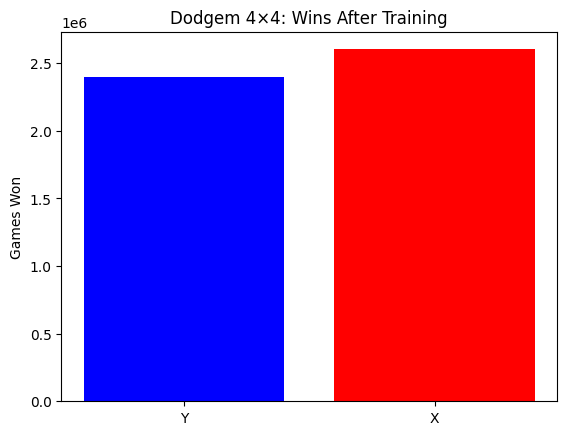

In [ ]:
# 📊 Графік
labels = list(results.keys())
values = [results[k] for k in labels]
plt.bar(labels, values, color=['blue', 'red'])
plt.title(f"Dodgem {board_size}×{board_size}: Wins After Training")
plt.ylabel("Games Won")
plt.show()

In [ ]:
# 📁 Формування унікального імені файлу
q_filename = f"Q_Dodgem_{board_size}x{board_size}_G{games_to_play}_lr{learning_rate}_eps{epsilon}.json"

# 🔄 Підготовка структури для збереження
def convert_qtable_to_serializable(qtable):
    serializable = {}
    for player in qtable:
        serializable[player] = {}
        for state, moves in qtable[player].items():
            serializable[player][state] = {str(k): v for k, v in moves.items()}
    return serializable

# 💾 Зберігання
with open(q_filename, "w") as f:
    json.dump(convert_qtable_to_serializable(q_table), f)

print(f"✅ Q-table saved to file: {q_filename}")

✅ Q-table saved to file: Q_Dodgem_4x4_G5000000_lr0.1_eps0.1.json
